In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
import os
import glob

In [81]:
from collections import namedtuple

In [3]:
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [6]:
from pymono.cifar import cifar_data_loader

In [7]:
from pymono.imagenette import imagenette_data_loader

In [8]:
from pymono.resnet_func import ResNet34 

In [9]:
from pymono.resnet_func import ResidualBlock 

In [10]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [11]:
logging.debug("hi")

# Convolutional Neural Networks (CNNs / ConvNets)

Convolutional Neural Networks are very similar to ordinary Neural Networks from the previous chapter: they are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. The whole network still expresses a single differentiable score function: from the raw image pixels on one end to class scores at the other. And they still have a loss function (e.g. SVM/Softmax) on the last (fully-connected) layer and all the tips/tricks we developed for learning regular Neural Networks still apply.

So what changes? ConvNet architectures make the explicit assumption that the inputs are images, which allows us to encode certain properties into the architecture. These then make the forward function more efficient to implement and vastly reduce the amount of parameters in the network.

## Architecture Overview

Convolutional Neural Networks take advantage of the fact that the input consists of images and they constrain the architecture in a more sensible way. In particular, unlike a regular Neural Network, the layers of a ConvNet have neurons arranged in 3 dimensions: width, height, depth. (Note that the word depth here refers to the third dimension of an activation volume, not to the depth of a full Neural Network, which can refer to the total number of layers in a network.) For example, the input images in CIFAR-10 are an input volume of activations, and the volume has dimensions 32x32x3 (width, height, depth respectively). The neurons in a layer will only be connected to a small region of the layer before it, instead of all of the neurons in a fully-connected manner. Moreover, the final output layer would for CIFAR-10 have dimensions 1x1x10, because by the end of the ConvNet architecture we will reduce the full image into a single vector of class scores, arranged along the depth dimension. Here is a visualization:

<img src="cnn2.png" alt="A CNN" />

## Layers used to build ConvNets
A simple ConvNet is a sequence of layers, and every layer of a ConvNet transforms one volume of activations to another through a differentiable function. We use three main types of layers to build ConvNet architectures: Convolutional Layer, Pooling Layer, and Fully-Connected Layer (exactly as seen in regular Neural Networks). We will stack these layers to form a full ConvNet architecture.

Example Architecture: Overview. A simple ConvNet for CIFAR-10 classification could have the architecture INPUT - CONV - RELU - POOL - FC. In more detail:

INPUT (32x32x3) will hold the raw pixel values of the image, in this case an image of width 32, height 32, and with three color channels R,G,B.

CONV layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as (32x32x12) if we decided to use 12 filters.

RELU layer will apply an elementwise activation function, such as the max(0,x)
 thresholding at zero. This leaves the size of the volume unchanged (32x32x12).
 
POOL layer will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as (16x16x12).

FC (i.e. fully-connected) layer will compute the class scores, resulting in volume of size (1x1x10), where each of the 10 numbers correspond to a class score, such as among the 10 categories of CIFAR-10. As with ordinary Neural Networks and as the name implies, each neuron in this layer will be connected to all the numbers in the previous volume.

In this way, ConvNets transform the original image layer by layer from the original pixel values to the final class scores. Note that some layers contain parameters and other don’t. In particular, the CONV/FC layers perform transformations that are a function of not only the activations in the input volume, but also of the parameters (the weights and biases of the neurons). On the other hand, the RELU/POOL layers will implement a fixed function. The parameters in the CONV/FC layers will be trained with gradient descent so that the class scores that the ConvNet computes are consistent with the labels in the training set for each image.

### In summary:

A ConvNet architecture is in the simplest case a list of Layers that transform the image volume into an output volume (e.g. holding the class scores)

There are a few distinct types of Layers (e.g. CONV/FC/RELU/POOL are by far the most popular)
Each Layer accepts an input 3D volume and transforms it to an output 3D volume through a differentiable function

Each Layer may or may not have parameters (e.g. CONV/FC do, RELU/POOL don’t)

Each Layer may or may not have additional hyperparameters (e.g. CONV/FC/POOL do, RELU doesn’t)

## Convolutional Layer

The Conv layer is the core building block of a Convolutional Network that does most of the computational heavy lifting.

### Overview and intuition without brain stuff. 

Let’s first discuss what the CONV layer computes without brain/neuron analogies. The CONV layer’s parameters consist of a set of learnable filters. Every filter is small spatially (along width and height), but extends through the full depth of the input volume. For example, a typical filter on a first layer of a ConvNet might have size 5x5x3 (i.e. 5 pixels width and height, and 3 because images have depth 3, the color channels). During the forward pass, we slide (more precisely, convolve) each filter across the width and height of the input volume and compute dot products between the entries of the filter and the input at any position. As we slide the filter over the width and height of the input volume we will produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. Intuitively, the network will learn filters that activate when they see some type of visual feature such as an edge of some orientation or a blotch of some color on the first layer, or eventually entire honeycomb or wheel-like patterns on higher layers of the network. Now, we will have an entire set of filters in each CONV layer (e.g. 12 filters), and each of them will produce a separate 2-dimensional activation map. We will stack these activation maps along the depth dimension and produce the output volume.

### The brain view. 

If you’re a fan of the brain/neuron analogies, every entry in the 3D output volume can also be interpreted as an output of a neuron that looks at only a small region in the input and shares parameters with all neurons to the left and right spatially (since these numbers all result from applying the same filter).

We now discuss the details of the neuron connectivities, their arrangement in space, and their parameter sharing scheme.

### Local Connectivity. 

When dealing with high-dimensional inputs such as images, as we saw above it is impractical to connect neurons to all neurons in the previous volume. Instead, we will connect each neuron to only a local region of the input volume. The spatial extent of this connectivity is a hyperparameter called the receptive field of the neuron (equivalently this is the filter size). The extent of the connectivity along the depth axis is always equal to the depth of the input volume. It is important to emphasize again this asymmetry in how we treat the spatial dimensions (width and height) and the depth dimension: The connections are local in 2D space (along width and height), but always full along the entire depth of the input volume.

#### Example 1. 

For example, suppose that the input volume has size (32x32x3)], (e.g. an RGB CIFAR-10 image). If the receptive field (or the filter size) is 5x5, then each neuron in the Conv Layer will have weights to a (5x5x3) region in the input volume, for a total of 5*5*3 = 75 weights (and +1 bias parameter). Notice that the extent of the connectivity along the depth axis must be 3, since this is the depth of the input volume.

#### Example 2. 

Suppose an input volume had size (16x16x20). Then using an example receptive field size of 3x3, every neuron in the Conv Layer would now have a total of 3*3*20 = 180 connections to the input volume. Notice that, again, the connectivity is local in 2D space (e.g. 3x3), but full along the input depth (20).

#### Example

An example input volume in red (e.g. a 32x32x3 CIFAR-10 image), and an example volume of neurons in the first Convolutional layer. Each neuron in the convolutional layer is connected only to a local region in the input volume spatially, but to the full depth (i.e. all color channels). Note, there are multiple neurons (5 in this example) along the depth, all looking at the same region in the input: the lines that connect this column of 5 neurons do not represent the weights (i.e. these 5 neurons do not share the same weights, but they are associated with 5 different filters), they just indicate that these neurons are connected to or looking at the same receptive field or region of the input volume, i.e. they share the same receptive field but not the same weights.

<img src="depthcol.png" alt="CNN conectivity" />

#### Spatial arrangement. 

We have explained the connectivity of each neuron in the Conv Layer to the input volume, but we haven’t yet discussed how many neurons there are in the output volume or how they are arranged. Three hyperparameters control the size of the output volume: the depth, stride and zero-padding. We discuss these next:

**First, the depth of the output volume is a hyperparameter**: *it corresponds to the number of filters we would like to use, each learning to look for something different in the input*. For example, if the first Convolutional Layer takes as input the raw image, then different neurons along the depth dimension may activate in presence of various oriented edges, or blobs of color. We will refer to a set of neurons that are all looking at the same region of the input as a depth column (some people also prefer the term fibre).

**Second, we must specify the stride with which we slide the filter**. When the stride is 1 then we move the filters one pixel at a time. When the stride is 2 (or uncommonly 3 or more, though this is rare in practice) then the filters jump 2 pixels at a time as we slide them around. This will produce smaller output volumes spatially.

**Sometimes it will be convenient to pad the input volume with zeros around the border**. The size of this zero-padding is a hyperparameter. The nice feature of zero padding is that it will allow us to control the spatial size of the output volumes (most commonly as we’ll see soon we will use it to exactly preserve the spatial size of the input volume so the input and output width and height are the same).

We can compute the spatial size of the output volume as a function of the input volume size (W), the receptive field size of the Conv Layer neurons (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. 

The correct formula for calculating how many neurons “fit” is given by (W−F+2P)/S+1

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output. 

In general, setting zero padding to be P=(F−1)/2 when the stride is S=1 ensures that the input volume and output volume will have the same size spatially.

#### Real-world example. 

The Krizhevsky et al. architecture that won the ImageNet challenge in 2012 accepted images of size (227x227x3). On the first Convolutional Layer, it used neurons with receptive field size **F=11**, stride **S=4** and no zero padding **P=0**. Since (227 - 11)/4 + 1 = 55, and since the Conv layer had a depth of **K=96**, the Conv layer output volume had size (55x55x96). Each of the 55*55*96 neurons in this volume was connected to a region of size (11x11x3) in the input volume. Moreover, all 96 neurons in each depth column are connected to the same (11x11x3) region of the input, but of course with different weights. 

#### Parameter Sharing. 

Parameter sharing scheme is used in Convolutional Layers to control the number of parameters. Using the real-world example above, we see that there are 55*55*96 = 290,400 neurons in the first Conv Layer, and each has 11*11*3 = 363 weights and 1 bias. Together, this adds up to 290400 * 364 = 105,705,600 parameters on the first layer of the ConvNet alone. Clearly, this number is very high.

It turns out that we can dramatically reduce the number of parameters by making one reasonable assumption: That if one feature is useful to compute at some spatial position (x,y), then it should also be useful to compute at a different position (x2,y2). In other words, denoting a single 2-dimensional slice of depth as a depth slice (e.g. a volume of size \[55x55x96] has 96 depth slices, each of size \[55x55]), we are going to constrain the neurons in each depth slice to use the same weights and bias. With this parameter sharing scheme, the first Conv Layer in our example would now have only 96 unique set of weights (one for each depth slice), for a total of 96*11*11*3 = 34,848 unique weights, or 34,944 parameters (+96 biases). Alternatively, all 55*55 neurons in each depth slice will now be using the same parameters. In practice during backpropagation, every neuron in the volume will compute the gradient for its weights, but these gradients will be added up across each depth slice and only update a single set of weights per slice.

Notice that if all neurons in a single depth slice are using the same weight vector, then the forward pass of the CONV layer can in each depth slice be computed as a convolution of the neuron’s weights with the input volume (Hence the name: Convolutional Layer). This is why it is common to refer to the sets of weights as a filter (or a kernel), that is convolved with the input.

#### Summary. 

To summarize, the Conv Layer:

- Accepts a volume of size W1×H1×D1
- Requires four hyperparameters:
    - Number of filters K,
    - Their spatial extent F,
    - The stride S,
    - The amount of zero padding P.
     
- Produces a volume of size W2×H2×D2, where:
    - W2=(W1−F+2P)/S+1
    - H2=(H1−F+2P)/S+1 (i.e. width and height are computed equally by symmetry)
D2=K

- With parameter sharing, it introduces F⋅F⋅D1 weights per filter, for a total of (F⋅F⋅D1)⋅K
 weights and K biases.

In the output volume, the d-th depth slice (of size W2×H2) is the result of performing a valid convolution of the d-th filter over the input volume with a stride of S, and then offset by d-th bias.

## Pooling Layer

It is common to periodically insert a Pooling layer in-between successive Conv layers in a ConvNet architecture. Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting. The Pooling Layer operates independently on every depth slice of the input and resizes it spatially, using the MAX operation. The most common form is a pooling layer with filters of size 2x2 applied with a stride of 2 downsamples every depth slice in the input by 2 along both width and height, discarding 75% of the activations. Every MAX operation would in this case be taking a max over 4 numbers (little 2x2 region in some depth slice). The depth dimension remains unchanged. More generally, the pooling layer:

- Accepts a volume of size W1×H1×D1
- Requires two hyperparameters:
    - their spatial extent F,
    - the stride S,
- Produces a volume of size W2×H2×D2, where:
    - W2=(W1−F)/S+1
    - H2=(H1−F)/S+1
    - D2=D1
- Introduces zero parameters since it computes a fixed function of the input
  
For Pooling layers, it is not common to pad the input using zero-padding.
It is worth noting that there are only two commonly seen variations of the max pooling layer found in practice: A pooling layer with F=3,S=2 (also called overlapping pooling), and more commonly F=2,S=2. Pooling sizes with larger receptive fields are too destructive.

#### General pooling. 

In addition to max pooling, the pooling units can also perform other functions, such as average pooling or even L2-norm pooling. Average pooling was often used historically but has recently fallen out of favor compared to the max pooling operation, which has been shown to work better in practice.

<img src="pool.png" alt="Pooling Layer" />

Pooling layer downsamples the volume spatially, independently in each depth slice of the input volume. Left: In this example, the input volume of size \[224x224x64] is pooled with filter size 2, stride 2 into output volume of size \[112x112x64]. Notice that the volume depth is preserved. 

<img src="maxpool.png" alt="MaxPool operation" />


## ConvNet Architectures

We have seen that Convolutional Networks are commonly made up of only three layer types: CONV, POOL (we assume Max pool unless stated otherwise) and FC (short for fully-connected). We will also explicitly write the RELU activation function as a layer, which applies elementwise non-linearity. In this section we discuss how these are commonly stacked together to form entire ConvNets.


### Layer Patterns

The most common form of a ConvNet architecture stacks a few CONV-RELU layers, follows them with POOL layers, and repeats this pattern until the image has been merged spatially to a small size. At some point, it is common to transition to fully-connected layers. The last fully-connected layer holds the output, such as the class scores. In other words, the most common ConvNet architecture follows the pattern:

INPUT -> \[\[CONV -> RELU]*N -> POOL?]*M -> \[FC -> RELU]*K -> FC

where the * indicates repetition, and the POOL? indicates an optional pooling layer. Moreover, N >= 0 (and usually N <= 3), M >= 0, K >= 0 (and usually K < 3). For example, here are some common ConvNet architectures you may see that follow this pattern:

INPUT -> FC, implements a linear classifier. Here N = M = K = 0.

INPUT -> CONV -> RELU -> FC

INPUT -> \[CONV -> RELU -> POOL]*2 -> FC -> RELU -> FC. Here we see that there is a single CONV layer between every POOL layer.

INPUT -> \[CONV -> RELU -> CONV -> RELU -> POOL]*3 -> \[FC -> RELU]*2 -> FC Here we see two CONV layers stacked before every POOL layer. This is generally a good idea for larger and deeper networks, because multiple stacked CONV layers can develop more complex features of the input volume before the destructive pooling operation.

**Prefer a stack of small filter CONV to one large receptive field CONV layer**. Suppose that you stack three 3x3 CONV layers on top of each other (with non-linearities in between, of course). In this arrangement, each neuron on the first CONV layer has a 3x3 view of the input volume. A neuron on the second CONV layer has a 3x3 view of the first CONV layer, and hence by extension a 5x5 view of the input volume. Similarly, a neuron on the third CONV layer has a 3x3 view of the 2nd CONV layer, and hence a 7x7 view of the input volume. Suppose that instead of these three layers of 3x3 CONV, we only wanted to use a single CONV layer with 7x7 receptive fields. These neurons would have a receptive field size of the input volume that is identical in spatial extent (7x7), but with several disadvantages. First, the neurons would be computing a linear function over the input, while the three stacks of CONV layers contain non-linearities that make their features more expressive. Second, if we suppose that all the volumes have C
 channels, then it can be seen that the single 7x7 CONV layer would contain C×(7×7×C)=49C2
 parameters, while the three 3x3 CONV layers would only contain 3×(C×(3×3×C))=27C$^2$
 parameters. Intuitively, stacking CONV layers with tiny filters as opposed to having one CONV layer with big filters allows us to express more powerful features of the input, and with fewer parameters. As a practical disadvantage, we might need more memory to hold all the intermediate CONV layer results if we plan to do backpropagation.

### Layer Sizing Patterns
Until now we’ve omitted mentions of common hyperparameters used in each of the layers in a ConvNet. We will first state the common rules of thumb for sizing the architectures and then follow the rules with a discussion of the notation:

**The input layer (that contains the image)** should be divisible by 2 many times. Common numbers include 32 (e.g. CIFAR-10), 64, 96 (e.g. STL-10), or 224 (e.g. common ImageNet ConvNets), 384, and 512.

**The conv layers should be using small filters (e.g. 3x3 or at most 5x5)**, using a stride of S=1, and crucially, padding the input volume with zeros in such way that the conv layer does not alter the spatial dimensions of the input. That is, when F=3, then using P=1
 will retain the original size of the input. When F=5, P=2. For a general F, it can be seen that P=(F−1)/2
 preserves the input size. If you must use bigger filter sizes (such as 7x7 or so), it is only common to see this on the very first conv layer that is looking at the input image.

**The pool layers are in charge of downsampling the spatial dimensions of the input**. The most common setting is to use max-pooling with 2x2 receptive fields (i.e. F=2), and with a stride of 2 (i.e. S=2). Note that this discards exactly 75% of the activations in an input volume (due to downsampling by 2 in both width and height). Another slightly less common setting is to use 3x3 receptive fields with a stride of 2, but this makes “fitting” more complicated (e.g., a 32x32x3 layer would require zero padding to be used with a max-pooling layer with 3x3 receptive field and stride 2). It is very uncommon to see receptive field sizes for max pooling that are larger than 3 because the pooling is then too lossy and aggressive. This usually leads to worse performance.

**Reducing sizing headaches**. The scheme presented above is pleasing because all the CONV layers preserve the spatial size of their input, while the POOL layers alone are in charge of down-sampling the volumes spatially. In an alternative scheme where we use strides greater than 1 or don’t zero-pad the input in CONV layers, we would have to very carefully keep track of the input volumes throughout the CNN architecture and make sure that all strides and filters “work out”, and that the ConvNet architecture is nicely and symmetrically wired.

**Why use stride of 1 in CONV?** Smaller strides work better in practice. Additionally, as already mentioned stride 1 allows us to leave all spatial down-sampling to the POOL layers, with the CONV layers only transforming the input volume depth-wise.

**Why use padding?** In addition to the aforementioned benefit of keeping the spatial sizes constant after CONV, doing this actually improves performance. If the CONV layers were to not zero-pad the inputs and only perform valid convolutions, then the size of the volumes would reduce by a small amount after each CONV, and the information at the borders would be “washed away” too quickly.

**Compromising based on memory constraints**. In some cases (especially early in the ConvNet architectures), the amount of memory can build up very quickly with the rules of thumb presented above. For example, filtering a 224x224x3 image with three 3x3 CONV layers with 64 filters each and padding 1 would create three activation volumes of size \[224x224x64]. This amounts to a total of about 10 million activations, or 72MB of memory (per image, for both activations and gradients). Since GPUs are often bottlenecked by memory, it may be necessary to compromise. In practice, people prefer to make the compromise at only the first CONV layer of the network. For example, one compromise might be to use a first CONV layer with filter sizes of 7x7 and stride of 2 (as seen in a ZF net). As another example, an AlexNet uses filter sizes of 11x11 and stride of 4.


# ResNet

One of the drawbacks of VGG was that it couldn't go as deep as wanted because it started to lose the generalization capability (i.e, it started overfitting). This is because as a neural network gets deeper, the gradients from the loss function start to shrink to zero and thus the weights are not updated. This problem is known as the vanishing gradient problem. ResNet essentially solved this problem by using skip connections.

<img src="resnet.png" alt="A Residual Block" />

In the figure above, we can see that, in addition to the normal connections, there is a direct connection that skips some layers in the model (skip connection).  With the skip connection, the output changes from h(x) = f(wx +b) to h(x) = f(x) + x. These skip connections help as they allow an alternate shortcut path for the gradients to flow through. 

The idea of shortcut connections (or skip connections) allows the model to skip layers and helps to mitigate the problem of vanishing gradients. These connections allow the gradients to be directly backpropagated to earlier layers, which makes the network easier to optimize.

What have those skip connections gained us? The key thing is that those extra layers, as they stand, are identity mapping, but they have parameters, which means they are trainable. So, when add the (say) 36 extra layers (in ResNet original paper), the model has the option to skip the layers, thus the new model is at least as good as the 20 layer model. Those extra 36 layers can then learn the parameters that make them most useful.

<img src="resnets_1.png" alt="Example of Residual Block" />

## Creating ResNets in Pure PyTorch

First, let's define the basic building block of a ResNet, the residual block:



In [12]:
class ResBlock(nn.Module):
    """
    Implements a residual block consisting in [Conv2d->BatchNorm2d->ReLU] + 
    [Conv2d->BatchNorm2d]. This residual is added to the input (then a second activation ReLU applied)
    
    If downsample = None (e.g, default first pass), then we obtain f(x) + x where 
    f(x) -> [Conv2d->BatchNorm2d->ReLU ->Conv2d->BatchNorm2d]. Otherwise the block is skipped. 
    
    """
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                                  stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                                  stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x # This is the residual (in the case of no downsample)
        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.downsample:  # this is the residual in the case of downsample
            residual = self.downsample(x)
            
        out += residual # This is it! f(x) + x 
        out = self.relu(out)

        return out


Below is the architecture of the 34-layer ResNet. 
As can be seen from the image below, we need to allow the model to go from 64 → 128 → 256 → 512 channels while decreasing the output size at the same time. 

<img src="fullresnet.png" alt="Original Resnet Architecture" />



## ResNet implementation

Now, we can define the full ResNet architecture. A ResNet is composed of several of these blocks stacked on top of each other. Here is a simple implementation of a ResNet:

In [25]:
class ResNet(nn.Module):
    """
    Implements the Residual Network with 34 layers:
    The architecture is like this:
    1. Image (assumed 224 x 224) passes through a convolution (kernel 7x7) 
    with stride = 2 and padding = 3which increases the features from 3 to 64 and 
    reduces spatial dimensiones from 224 to (224 - 7 -2*3 +1)/2 =112, then batch normalization, 
    activation and MaxPool2d which further reduces dimensions to 56.
    2. The layer architecture is as follows (with a skip connection between each pair of layers) 
        6 layers of convolution 3x3 with 64 features
        8 layers of convolution 3x3 with 128 features (max pool 56 -> 28)
        12 layers of convolution 3x3 with 256 features (max pool 28 -> 24)
        6 layers of convolution 3x3 with 512 features (max pool 14 -> 7)
    3. Then avgpool and fc.
    
    """
    def __init__(self, block, layers, num_classes = 10, debug=False):
        super(ResNet, self).__init__()
        self.debug = debug
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        if self.debug:
            print(f" ## make_layer: planes = {planes},  blocks = {blocks}, stride = {stride}")
            print(f" ## make_layer: in_planes={self.inplanes}")
            print(f" ## make_layer: downsample = {downsample}")
            print(f"layer block = 0: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = {stride}, downsample = {downsample}")
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            if self.debug:
                print(f" layer block = {i}: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = 1, downsample = None")

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        if(self.debug): print(f" ResNet: input data shape =>{x.shape}")
            
        x = self.conv1(x)
        if(self.debug): print(f" ResNet: after conv1 =>{x.shape}")
            
        x = self.maxpool(x)
        if(self.debug): print(f" ResNet: after maxpool =>{x.shape}")
            
        x = self.layer0(x)
        if(self.debug): print(f" ResNet: after layer0 =>{x.shape}")
        
        x = self.layer1(x)
        if(self.debug): print(f" ResNet: after layer1 =>{x.shape}")
            
        x = self.layer2(x)
        if(self.debug): print(f" ResNet: after layer2 =>{x.shape}")
            
        x = self.layer3(x)
        if(self.debug): print(f" ResNet: after layer3 =>{x.shape}")
            
        x = self.avgpool(x)
        if(self.debug): print(f" ResNet: after avgpool =>{x.shape}")
            
        x = x.view(x.size(0), -1)
        if(self.debug): print(f" ResNet: after view =>{x.shape}")
            
        x = self.fc(x)
        if(self.debug): logging.debug(f" ResNet: after fc =>{x.shape}")

        self.debug = False
        return x


In this code, the ```_make_layer``` function is used to create each layer of the network, which consists of several residual blocks with the same output size. The stride is set to 2 for the first block of each layer (except the first layer), which reduces the spatial dimensions of the output by half, effectively making it a downsampling layer.

The forward function defines the forward pass of the network. The input is passed through each layer in turn, and finally reshaped and passed through a fully connected layer to produce the output.



## Training the Basic Building Block in PyTorch

Now that we have defined our basic building block and the complete ResNet architecture let's train our model. We will use the PyTorch library to train our ResNet on the ImageNette dataset.


# CIFAR

In this article, we will be using the famous [CIFAR-10](https://www.cs.toronto.edu/%7Ekriz/cifar.html?ref=blog.paperspace.com) dataset, which has become one of the the most common choice for beginner computer vision datasets. The dataset is a labeled subset of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, and things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.


In [15]:
# without normalization and without resizing, for display

test_loader_nn = cifar_data_loader(data_dir='./data', norm=False, test=True,
                                   batch_size=64)

Files already downloaded and verified


Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])
torch.Size([3, 32, 32])


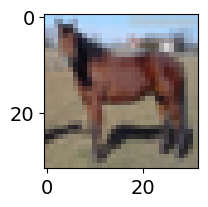

Label: 7


In [16]:
# Display image and label.
plt.rcParams["figure.figsize"] = 2, 2
train_features, train_labels = next(iter(test_loader_nn))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
print(img.shape)
#plt.imshow(img.T)
#print(img)
plt.imshow(transforms.ToPILImage()(img))
#plt.imshow(img.permute(*torch.arange(img.ndim - 1, -1, -1)))
plt.show()
print(f"Label: {label}")
plt.rcParams["figure.figsize"] = 10, 8

In [17]:
# CIFAR10 dataset 
train_loader_cf, valid_loader_cf = cifar_data_loader(data_dir='./data',
                                         batch_size=64)

test_loader_cf = cifar_data_loader(data_dir='./data',
                              batch_size=64,
                              test=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [18]:
total_step = len(train_loader_cf)
print(f"length of train series: {total_step}")
train_features, train_labels = next(iter(test_loader_cf))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

length of train series: 704
Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


In [26]:
#define the model
model = ResNet(ResBlock, [3, 4, 6, 3], debug=True).to(device)


 ## make_layer: planes = 64,  blocks = 3, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
layer block = 0: Block(in_channels=64, out_channels =64, stride = 1, downsample = None
 layer block = 1: Block(in_channels=64, out_channels =64, stride = 1, downsample = None
 layer block = 2: Block(in_channels=64, out_channels =64, stride = 1, downsample = None
 ## make_layer: planes = 128,  blocks = 4, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
layer block = 0: Block(in_channels=64, out_channels =128, stride = 2, downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 layer block = 1: Block(in_channels=128, out_channels =128, stride = 1, downsample = None
 layer block = 2

In [27]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)  


In [33]:
def single_run(train_loader, device, model, optimizer):
    print(f"** Run for 1 event**")

    for epoch in range(1):
        print(f"epoch = {epoch}")
    
        for i, (images, labels) in enumerate(train_loader):  
            if i>1: break
            print(f"i = {i}")
            print(f"labels = {labels}")
            images = images.to(device)
            labels = labels.to(device)
            
            model.train()
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)

            print(f"outputs = {outputs.data.shape}")
            _, predicted = torch.max(outputs.data, 1)
            print(f"predicted label = {predicted}")
            correct = (predicted == labels).sum().item()
            print(f"correct = {correct}")
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            
            loss.backward()
            optimizer.step()
    
            print(f"Train Step {i + 1}/{len(train_loader)}, Loss: {loss.data.item()}")
                


In [34]:
single_run(train_loader_cf, device, model, optimizer)

** Run for 1 event**
epoch = 0
i = 0
labels = tensor([2, 2, 4, 3, 7, 8, 0, 6, 1, 3, 1, 4, 5, 9, 6, 2, 8, 2, 4, 3, 3, 5, 6, 3,
        2, 9, 6, 9, 9, 7, 1, 4, 5, 4, 6, 2, 1, 1, 3, 8, 9, 8, 2, 0, 9, 6, 5, 9,
        9, 8, 2, 3, 7, 6, 7, 7, 7, 1, 6, 3, 5, 5, 2, 6])
outputs = torch.Size([64, 10])
predicted label = tensor([6, 1, 3, 1, 6, 5, 1, 1, 8, 1, 7, 5, 1, 1, 6, 1, 4, 6, 3, 5, 6, 6, 6, 6,
        6, 1, 3, 1, 1, 6, 1, 6, 6, 1, 6, 5, 1, 4, 3, 3, 6, 1, 6, 1, 1, 1, 7, 1,
        1, 5, 6, 1, 1, 1, 1, 8, 6, 1, 1, 1, 2, 6, 4, 4], device='mps:0')
correct = 7
Train Step 1/704, Loss: 2.358034133911133
i = 1
labels = tensor([4, 6, 5, 8, 7, 9, 4, 4, 7, 7, 4, 8, 9, 8, 9, 3, 5, 0, 5, 0, 5, 2, 1, 0,
        4, 5, 2, 4, 5, 5, 4, 2, 9, 7, 7, 8, 1, 0, 9, 6, 9, 8, 7, 2, 2, 2, 5, 0,
        4, 7, 6, 7, 4, 5, 1, 7, 8, 2, 6, 2, 5, 2, 9, 0])
outputs = torch.Size([64, 10])
predicted label = tensor([6, 3, 3, 6, 8, 8, 6, 6, 8, 8, 6, 8, 7, 8, 8, 8, 8, 9, 8, 8, 8, 4, 8, 8,
        6, 8, 6, 2, 4, 6, 6, 6, 9, 6, 8,

## Imagenette

In [35]:
# without normalization and without resizing, for display

test_loader_nn = imagenette_data_loader(norm=False, test=True)

Reading imaginette
case test and norm false


In [36]:
batch_features, batch_labels  = next(iter(test_loader_nn))
batch_features.shape, batch_features.dtype

(torch.Size([32, 3, 128, 128]), torch.float32)

In [37]:
(batch_features[0].squeeze()).shape

torch.Size([3, 128, 128])

In [38]:
batch_labels.shape, batch_labels.dtype

(torch.Size([32]), torch.int64)

In [39]:
batch_labels[0].item()

0

torch.Size([3, 128, 128])


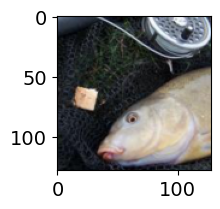

Label: 0


In [40]:
# Display image and label.
plt.rcParams["figure.figsize"] = 2, 2
img = batch_features[0].squeeze()
label = batch_labels[0].item()
print(img.shape)
#plt.imshow(img.T)
#print(img)
plt.imshow(transforms.ToPILImage()(img))
#plt.imshow(img.permute(*torch.arange(img.ndim - 1, -1, -1)))
plt.show()
print(f"Label: {label}")
plt.rcParams["figure.figsize"] = 10, 8

In [41]:
trainloader_im, testloader_im = imagenette_data_loader()

Reading imaginette


In [42]:
single_run(trainloader_im, device, model, optimizer)

** Run for 1 event**
epoch = 0
i = 0
labels = tensor([8, 9, 9, 1, 4, 2, 4, 1, 7, 2, 6, 7, 8, 8, 9, 3, 1, 0, 1, 9, 7, 6, 3, 8,
        3, 6, 3, 6, 9, 2, 4, 5])
outputs = torch.Size([32, 10])
predicted label = tensor([7, 2, 9, 2, 7, 9, 2, 4, 7, 9, 2, 2, 4, 8, 2, 7, 2, 7, 2, 4, 4, 8, 2, 4,
        8, 2, 8, 7, 9, 4, 7, 9], device='mps:0')
correct = 4
Train Step 1/296, Loss: 2.4964354038238525
i = 1
labels = tensor([6, 7, 1, 8, 6, 4, 4, 9, 1, 3, 2, 0, 4, 9, 1, 8, 5, 8, 7, 7, 2, 9, 6, 6,
        9, 8, 5, 6, 7, 4, 7, 4])
outputs = torch.Size([32, 10])
predicted label = tensor([9, 4, 4, 2, 2, 9, 9, 4, 4, 2, 4, 7, 2, 9, 4, 4, 4, 4, 4, 4, 2, 9, 7, 9,
        9, 4, 7, 4, 4, 8, 4, 4], device='mps:0')
correct = 5
Train Step 2/296, Loss: 2.5212342739105225


In [44]:
num_classes = 10
num_epochs = 5
batch_size = 32
learning_rate = 0.01


In [45]:
#define the model
model = ResNet(ResBlock, [3, 4, 6, 3], debug=False).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  


In [54]:
def train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
              iprnt=100, epochs=10):
    """
    train the CNN
    """
    train_losses, val_losses, acc = [], [], []
    print(f"Running for epochs ->{epochs}")
    
    for epoch in range(epochs):
        train_losses_epoch, val_losses_epoch = [], []

        print(f"\nEPOCH {epoch}")

        print(f"Training step: size of sample {len(train_loader)}")
        for i, (images, labels) in enumerate(train_loader):

            images = images.to(device)
            labels = labels.to(device)

            model.train()  #Sets the module in training mode.
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            outputs = model(images) # image --> model --> (x,y,z)
            loss = criterion(outputs, labels) # compare labels with predictions
            loss.backward()  # backward pass
            optimizer.step()
            
            train_losses_epoch.append(loss.data.item())
            if((i+1) % (iprnt) == 0):
                print(f"Train Step {i + 1}/{len(train_loader)}, Loss: {loss.data.item()}")
                
        
        # Validation step
        with torch.no_grad():  #gradients do not change
            model.eval()       # Sets the module in evaluation mode.
            correct = 0
            total = 0
            print(f"Validation step: size of sample {len(val_loader)}")
            for i, (images, labels) in enumerate(val_loader):

                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_losses_epoch.append(loss.data.item())
                
                if((i+1) % (iprnt) == 0):
                    logging.debug(f"Validation Step {i + 1}/{len(val_loader)}, Loss: {loss.data.item()}")

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_losses.append(np.mean(train_losses_epoch))
        val_losses.append(np.mean(val_losses_epoch))
        acc.append(100 * correct / total)
        
        print(f"--- EPOCH {epoch} AVG TRAIN LOSS: {np.mean(train_losses_epoch)}")
        print(f"--- EPOCH {epoch} AVG VAL LOSS: {np.mean(val_losses_epoch)}")
        print(f'Accuracy on the {len(val_loader)} validation images: {100 * correct / total} %') 
    
    return train_losses, val_losses, acc


In [55]:
# CIFAR run

In [56]:
train_losses, val_losses, acc = train_cnn(train_loader_cf, test_loader_cf, model, optimizer, device, criterion, 
                                     epochs=5, iprnt=100)

Running for epochs ->5

EPOCH 0
Training step: size of sample 704
Train Step 100/704, Loss: 0.6570014953613281
Train Step 200/704, Loss: 0.6553725004196167
Train Step 300/704, Loss: 0.6198410987854004
Train Step 400/704, Loss: 0.798586368560791
Train Step 500/704, Loss: 0.7279900312423706
Train Step 600/704, Loss: 0.566392719745636
Train Step 700/704, Loss: 0.4475692808628082
Validation step: size of sample 157
--- EPOCH 0 AVG TRAIN LOSS: 0.6768143937330354
--- EPOCH 0 AVG VAL LOSS: 0.713763211942782
Accuracy on the 157 validation images: 75.98 %

EPOCH 1
Training step: size of sample 704
Train Step 100/704, Loss: 0.45128095149993896
Train Step 200/704, Loss: 0.3641168475151062
Train Step 300/704, Loss: 0.7854185104370117
Train Step 400/704, Loss: 0.6365230083465576
Train Step 500/704, Loss: 0.7761870622634888
Train Step 600/704, Loss: 0.5050977468490601
Train Step 700/704, Loss: 0.688204288482666
Validation step: size of sample 157
--- EPOCH 1 AVG TRAIN LOSS: 0.5397435309026729
--- EP

In [57]:
acc

[75.98, 79.62, 78.22, 79.74, 75.38]

In [58]:
# IMAGENETTE run

In [60]:
train_losses2, val_losses2, acc2 = train_cnn(trainloader_im, testloader_im, model, optimizer, device, criterion, 
                                     epochs=5, iprnt=50)

Running for epochs ->5

EPOCH 0
Training step: size of sample 296
Train Step 50/296, Loss: 1.0985435247421265
Train Step 100/296, Loss: 1.3814918994903564
Train Step 150/296, Loss: 0.9700369834899902
Train Step 200/296, Loss: 0.9032450914382935
Train Step 250/296, Loss: 1.0057369470596313
Validation step: size of sample 123
--- EPOCH 0 AVG TRAIN LOSS: 1.2560687312805974
--- EPOCH 0 AVG VAL LOSS: 0.9586209107220658
Accuracy on the 123 validation images: 69.14649681528662 %

EPOCH 1
Training step: size of sample 296
Train Step 50/296, Loss: 0.8751517534255981
Train Step 100/296, Loss: 0.7691064476966858
Train Step 150/296, Loss: 0.7780991792678833
Train Step 200/296, Loss: 0.8636380434036255
Train Step 250/296, Loss: 0.7194346785545349
Validation step: size of sample 123
--- EPOCH 1 AVG TRAIN LOSS: 0.8305900157303423
--- EPOCH 1 AVG VAL LOSS: 0.9103185192840856
Accuracy on the 123 validation images: 69.8343949044586 %

EPOCH 2
Training step: size of sample 296
Train Step 50/296, Loss: 0.

## Using wandb

In [61]:
import wandb

In [62]:
# Initialize wandb
wandb.init(project="resnet-tutorial")


wandb: Currently logged in as: jjgomezcadenas (dipc). Use `wandb login --relogin` to force relogin


In [89]:
config={
          "dataset": "Imagenette",
          "num_classes": 10,
          "epochs": 10,
          "learning_rate": 0.01,
          "weight_decay": 0.001,
          "momentum": 0.9,
          "batch_size": 64,
          "architecture": "Resnet34",
        
      }
project = "resnet-tutorial"
run ="imagnette-run"

In [90]:
config

{'dataset': 'Imagenette',
 'num_classes': 10,
 'epochs': 10,
 'learning_rate': 0.01,
 'weight_decay': 0.001,
 'momentum': 0.9,
 'batch_size': 64,
 'architecture': 'Resnet34'}

In [91]:
configx = namedtuple("configx", "dataset num_classes epochs learning_rate weight_decay momentum batch_size architecture  ")

In [92]:
configx(**config)

configx(dataset='Imagenette', num_classes=10, epochs=10, learning_rate=0.01, weight_decay=0.001, momentum=0.9, batch_size=64, architecture='Resnet34')

In [118]:
from tqdm.auto import tqdm


In [110]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="resent34-im", config=hyperparameters):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, train_loader, test_loader, criterion, optimizer = make(config)
      #print(model)

      # and use them to train the model
      train(model, train_loader, criterion, optimizer, config)

      # and test its final performance
      test(model, test_loader)

    return model

In [111]:
def make(config):
    # Make the data
    ##train, test = get_data(train=True), get_data(train=False)
    #train_loader = make_loader(train, batch_size=config.batch_size)
    #test_loader = make_loader(test, batch_size=config.batch_size)

    train_loader, test_loader =  imagenette_data_loader(batch_size=config.batch_size)

    # Make the model
    model = ResNet(ResBlock, [3, 4, 6, 3], debug=False).to(device)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=config.learning_rate, 
                                weight_decay = config.weight_decay, 
                                momentum = config.momentum)  
   
    return model, train_loader, test_loader, criterion, optimizer


In [112]:
model, train_loader, test_loader, criterion, optimizer = make(configx(**config))

Reading imaginette


In [113]:
def train(model, loader, criterion, optimizer, config):
    # tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Run training and track with wandb
    total_batches = len(loader) * config.epochs
    example_ct = 0  # number of examples seen
    batch_ct = 0
    for epoch in tqdm(range(config.epochs)):
        for _, (images, labels) in enumerate(loader):

            loss = train_batch(images, labels, model, optimizer, criterion)
            example_ct +=  len(images)
            batch_ct += 1

            # Report metrics every 25th batch
            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)


In [114]:
def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)
    
    model.train()
    
    # Forward pass ➡
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

In [115]:
def train_log(loss, example_ct, epoch):
    loss = float(loss)

    # where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")
 

In [116]:
def test(model, test_loader):
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"test images: {correct / total:%}")
        
        wandb.log({"test_accuracy": correct / total})

    # Save the model in the exchangeable ONNX format
    
   torch.onnx.export(model, images, "resnet34_im.onnx")
    wandb.save("resnet34_im.onnx")  

In [122]:
model = model_pipeline(config)

Reading imaginette
ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0

  0%|          | 0/10 [00:00<?, ?it/s]

Loss after 01536 examples: 2.033
Loss after 03136 examples: 1.922
Loss after 04736 examples: 1.759
Loss after 06336 examples: 1.679
Loss after 07936 examples: 1.568
Loss after 09533 examples: 1.356
Loss after 11133 examples: 1.719
Loss after 12733 examples: 1.160
Loss after 14333 examples: 1.212
Loss after 15933 examples: 1.308
Loss after 17533 examples: 1.890
Loss after 19130 examples: 1.140
Loss after 20730 examples: 1.607
Loss after 22330 examples: 1.158
Loss after 23930 examples: 1.144
Loss after 25530 examples: 0.985
Loss after 27130 examples: 1.118
Loss after 28727 examples: 1.083
Loss after 30327 examples: 0.948
Loss after 31927 examples: 1.025
Loss after 33527 examples: 0.973
Loss after 35127 examples: 0.939
Loss after 36727 examples: 1.263
Loss after 38324 examples: 0.694
Loss after 39924 examples: 0.849
Loss after 41524 examples: 0.743
Loss after 43124 examples: 0.802
Loss after 44724 examples: 0.589
Loss after 46324 examples: 0.840
Loss after 47921 examples: 0.602
Loss after

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
loss,██▇▆▅▄▄▇▄▄▄▄▄▄▃▅▂▂▃▃▂▃▂▃▄▃▃▃▂▁▂▁▂▁▁▂▁▁▁▂
test_accuracy,▁
epoch,9
loss,0.77311
test_accuracy,0.66955
